### Hotel Review Classifier (working title)

*Flatiron School Data Science Bootcamp*

Captsone Project - NLP Sentiment/Ratings Analysis

Anna D'Angela | [annaadangela@gmail.com](mailto:annaadangela@gmail.com)

[Return to GitHub repo](https://github.com/anna-dang/mod05-capstone) 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anna-dang/mod05-capstone/blob/main/NLP_processing.ipynb)

<!-- FROM GITHUB: Replace "github.com" to "colab.research.google.com/github". 
For example, if the URL on GitHub is https://github.com/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb, it should be replaced to https://colab.research.google.com/github/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb.

FROM COLAB: Select File -> Open notebook...
Input the URL on GitHub (e.g. https://github.com/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb) into "Enter a GitHub URL or search by organization or user" on GITHUB tab.
 -->

In [ ]:
# # Link to py file in Colab:
# # Manually upload into content/drive or use this to open pop-up window
# from google.colab import files
# src = list(files.upload().values())[0]

# # Link to py file from path, then import as usual
# open('/content/NLP_functions.py','wb').write(src)
# import collection_functions as cf
#
# # Save changes: 
# # Push Colab to GitHub and pull that locally
# # Download .ipynb and replace locally

# EDA TODO
- upgrade plot design
- organize libraries

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import plotly.express as px
import geopandas as gpd

import plotly.graph_objects as go
import pandas as pd
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


# My custome functions
from capstone_functions import NLP_functions as NLP
seed = 619

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Import data and explore

In [5]:
# import test data
df_raw = pd.read_csv("./data/clean_scrape.csv")
display(df_raw.head())

# check for null/value types
df_raw.info()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Easy check in and check out process using the ...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,We needed a last-minute place to stay in Denve...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,We love Hyatt hotels and have had many great e...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,"I have never encountered such helpful, friendl...",5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,"We love it here! Great service, they usually r...",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22217 entries, 0 to 22216
Data columns (total 5 columns):
Location    22217 non-null object
Hotel       22217 non-null object
Title       22217 non-null object
Review      22217 non-null object
Rating      22217 non-null int64
dtypes: int64(1), object(4)
memory usage: 868.0+ KB


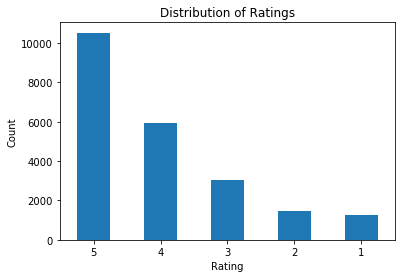

In [6]:
# Examine class distribution by count
df_raw['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

In [7]:
# Examine imbalance as percentage
percent = round(df_raw['Rating'].value_counts(1).to_frame(name='Percent %').rename_axis('Rating') * 100, 2)
percent

,Percent %
Rating,
5,47.36
4,26.66
3,13.62
2,6.69
1,5.67


There is a significant imbalance in classes. First I will randomly undersample the most major class, 5 by equalizing the amount with the second highest class, 4. This is to reduce the dimensions for the model by growing the total corpus largely positive.

In [8]:
tot_5 = df_raw[df_raw['Rating'] == 5].count()[0] 
tot_4 = df_raw[df_raw['Rating'] == 4].count()[0] 
drop_n = tot_5 - tot_4
drop_n

4600

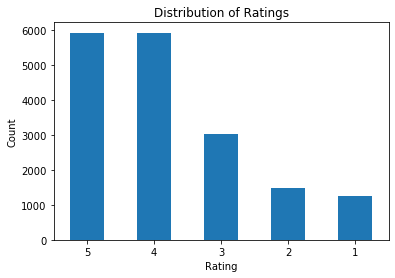

In [9]:
test = df_raw.drop(df_raw[df_raw['Rating'].eq(5)].sample(drop_n, random_state=seed).index)

# Examine class distribution by randomly reducing the most major class
test['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

Remaining class imbalance is less sever, I will address this by using class weights when modeling.

### Collection distribution

In [10]:
# Examine collection distribution by location
avg_df = df_raw.groupby(by = 'Hotel')[['Rating']].agg(['count', 'mean'])

coords = pd.read_csv("./data/coordinates.csv", names = ['Hotel', 'Lat', 'Long'])

map_df = pd.merge(avg_df, coords, on = 'Hotel')
map_df

,Hotel,"(Rating, count)","(Rating, mean)",Lat,Long
0,Baymont by Wyndham Denver International Airport,2094,3.949379,39.820740,-104.770119
1,Best Western Plus Denver International Airport...,1000,3.633000,39.824161,-104.770178
2,Clarion Hotel Denver Central,920,3.372826,39.783300,-104.990895
3,DoubleTree by Hilton Hotel Denver,2000,3.859500,39.763101,-104.904370
4,Embassy Suites by Hilton Denver International ...,1000,3.996000,39.824143,-104.775354
5,Grand Hyatt Denver Downtown,1000,4.488000,39.745762,-104.988802
6,Hilton Denver City Center,1000,4.101000,39.747159,-104.990145
7,Hyatt Place Denver/Cherry Creek,995,4.156784,39.695828,-104.938547
8,Hyatt Regency Denver At Colorado Convention Ce...,2000,4.460000,39.744213,-104.993667
9,La Quinta Inn & Suites by Wyndham Denver Airpo...,1000,3.803000,39.820897,-104.773078


In [74]:
# View hotels on map
map_df['text'] = (map_df['Hotel'] + ', # Reviews: ' + 
                  map_df[('Rating', 'count')].astype(str) + ', Rating: ' 
                  + map_df[('Rating', 'mean')].astype(str))

px.set_mapbox_access_token(open("./driver/mapbox_token").read())

fig = px.scatter_mapbox(map_df,
                        lat='Lat',
                        lon='Long',
                        hover_name='text',
                        zoom=10)
fig.show()

### Pre-processing

In [33]:
# combine 'Title' and 'Review' into one chunk of text (seperate with a space)
df_raw['Review'] = df_raw['Title'] + ' ' + df_raw['Review']
df_raw.head()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Great View Easy check in and check out process...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,Clean and Comfortable We needed a last-minute ...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,Excellent Staff & Service We love Hyatt hotels...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,Trip to Denver - a Hallmark Christmas I have n...,5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,Our 'see downtown' hotel We love it here! Grea...,5


In [34]:
# Drop columns uneeded for this analysis, save as working df
df = df_raw.drop(columns = ['Location', 'Hotel', 'Title'])
df.head()

,Review,Rating
0,Great View Easy check in and check out process...,5
1,Clean and Comfortable We needed a last-minute ...,5
2,Excellent Staff & Service We love Hyatt hotels...,5
3,Trip to Denver - a Hallmark Christmas I have n...,5
4,Our 'see downtown' hotel We love it here! Grea...,5


### Train / Test Split

# TODO:
1) **Split the sample data into 3 groups**: train, validation and test, where train is used to fit the model, validation is used to evaluate fitness of interim models, and test is used to assess final model fitness.

2) **Split the sample data into 2 groups**: train and test, where train is further split into train and validation set k times using k-fold cross validation, and test is used to assess final model fitness. With k-fold cross validation:

In [35]:
# Split BEFORE processsing to avoid leaking
X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=seed)

X_train.shape, X_test.shape

# Words in test but not in train - decode_error = ignore

((16662,), (5555,))

In [37]:
y_train.value_counts(1) * 100

5    47.503301
4    26.407394
3    13.551795
2     6.871924
1     5.665586
Name: Rating, dtype: float64

### NLP Preprocessing
Transform unstructured data to a matrix of numbers. Fits to entire training data 'X_train' to build entire corpus.

#### Feature Engineering for Text Data
- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Start at baseline model, then adjust and see results.

# NLP TODO

- visuals: word cloud, freq dist, etc.

- tokenizer pipeline????

- DROP common words: hotel, room, Denver..... non-signally common occuring to give model most meaningful pool

In [ ]:
# # from medium
# def preprocess_text(text):
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
#     # Remove stop words
#     keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
#     return keywords
# # Create an instance of TfidfVectorizer
# vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# # Fit to the data and transform to feature matrix
# X_train_tfidf = vectoriser.fit_transform(X_train)
# X_train_tfidf.shape

In [58]:
# cleaning - remove punctuation, captialization, regex for conjunctions
# more complex: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"


In [62]:
# tokenize

corpus = df['Review']

tokens = word_tokenize(','.join(corpus))


In [65]:
# remove stops words, reduce dimensionality
stopword_list = stopwords.words('english')
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [66]:
# punctuation
stopword_list.extend(string.punctuation)
stopword_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [67]:
# remove
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopword_list]

In [ ]:
# pull out hotel titles/names? make more generic?

In [70]:
# visual: freqeuncy distribution/N-grams
freq = nltk.FreqDist(stopped_tokens)
freq.most_common(100)

# PLOT total

# plot each class

# any to remove??? (appearing in all classes)

[('hotel', 29954),
 ('room', 22180),
 ('great', 15302),
 ('stay', 14232),
 ('staff', 12406),
 ('denver', 9731),
 ('nice', 9425),
 ('good', 8927),
 ('clean', 8541),
 ('would', 8219),
 ("n't", 8178),
 ('rooms', 7844),
 ('location', 7808),
 ('service', 7505),
 ('airport', 6986),
 ('breakfast', 6974),
 ('one', 6532),
 ('stayed', 5829),
 ('night', 5599),
 ('friendly', 5591),
 ('desk', 5469),
 ("'s", 5407),
 ('comfortable', 5340),
 ('us', 5295),
 ('get', 5166),
 ('front', 4880),
 ('time', 4870),
 ('shuttle', 4647),
 ('place', 4587),
 ('downtown', 4405),
 ('could', 4374),
 ('...', 4279),
 ('well', 4098),
 ('also', 3919),
 ('free', 3896),
 ('floor', 3840),
 ('like', 3693),
 ('area', 3625),
 ('helpful', 3568),
 ('bed', 3527),
 ('back', 3352),
 ('food', 3323),
 ('parking', 3306),
 ('excellent', 3281),
 ('really', 3247),
 ('check', 3215),
 ('day', 3155),
 ('’', 3018),
 ('lobby', 2982),
 ('next', 2966),
 ('close', 2965),
 ('restaurant', 2942),
 ('even', 2866),
 ('street', 2799),
 ('restaurants', 2

In [ ]:
# EXPLORE THIS, likely note necessary 
# stem or lemm to reduce words to base

lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('feet')) # foot

In [ ]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopword_list,decode_error='ignore')

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf#.todense()

In [ ]:
# vectorize - BOW

In [ ]:
# examine sparce matrix

In [ ]:
# TF-IDF - which words appear heavily in one class vs others

In [ ]:
# EDA/visuals: word freq, word cloud, etc.

In [ ]:
# Optional ... EDA - compare sentiment libraries predictions to given rating - how "accurate" is it in this case?

# Modeling
https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267

# TODO
- choose metric
- build evaluation function (confusion matrix, metrics.classification_report, opt:feature importances?)        
- baseline model   
- model iterations
        
        naive bayes?
        random forest?
        SGDClassifier?
        
- multi-class models?
        
- establish **CLASS WEIGHTS** to deal with imbalance

- feature importance plot (function?)

   

### Baseline Model - Naive Bayes Pipeline

In [54]:
# build pipeline for vectorizers/NLP (text processor)
count_vect = CountVectorizer()
tf_transform = TfidfTransformer(use_idf=True)

text_pipe = Pipeline(steps=[
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

In [55]:
# fit_transform to clean X_train, transform X_train and X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

<16662x22275 sparse matrix of type '<class 'numpy.float64'>'
	with 1106896 stored elements in Compressed Sparse Row format>

In [56]:
# full_pipe = vect_pipe + model_pipe

# BALANCE WEIGHTS

full_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf', RandomForestClassifier(class_weight='balanced'))])
full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                 ('tf_transformer', TfidfTransformer())])),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

In [ ]:
# fit_transform to X_train_pipe, fit to X_test_pipe, predict and score

In [73]:
# Grid search - fit to raw X_train since it will go through the tokenizer

#EXAMPLE FROM LECTURE:

## Make a tokenizer with TweetTokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
vectorizer = CountVectorizer()
## Make params Grid
#### use_idf: True/False
#### tokenizer: None, tokenizer.tokenize
#### criterion: gini, entropy
#### stopwords

params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None, tokenizer.tokenize],
         'text_pipe__count_vectorizer__stop_words':[None, stopword_list],
         'clf__criterion':['gini', 'entropy']}

## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)
grid.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
# Display best params
display(grid.best_params_)

# Save best pipe
best_pipe = grid.best_estimator_

In [ ]:
# View best pipe
set_config(display='diagram')
best_pipe

In [43]:
# Evaluate model
NLP.evaluate_model(best_pipe, X_test, y_test)

TypeError: evaluate_model() missing 3 required positional arguments: 'model', 'images', and 'labels'

In [ ]:
# feature importance
# from NLTK

# get words NLTK
vectorizer.get_feature_names()

# get importances from model (rf in this case), set names as index
importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())
importance

importance.sort_values(ascending=True).tail(20).plot(kind='barh')

In [ ]:
# get features importance
# from a pipeline

# number features
X_train_pipe.shape

# get names
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()

# preview
features[:10]

#
len(features)